<a href="https://colab.research.google.com/github/vishal122003/Vishal_Gen-ai/blob/main/model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# import the libaries

import numpy as np
import cv2,glob,os
import matplotlib.image as mpimg
from skimage.transform import resize
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from keras.models import model_from_json
import matplotlib.pyplot as plt

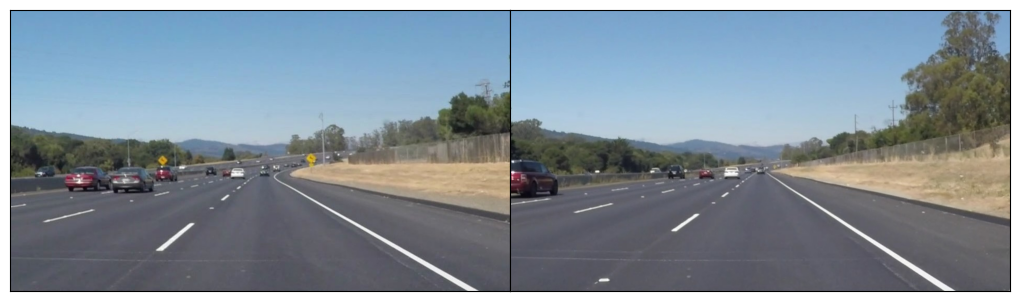

In [26]:
# plot the testing image

# show the images
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols

    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

test_images = [plt.imread(path) for path in glob.glob('/content/drive/MyDrive/test_images/*.jpg')]

show_images(test_images)



In [27]:
# Load pretrained model

# load the model json file
json_file = open('/content/drive/MyDrive/model.json', 'r')
json_model = json_file.read()
json_file.close()

# load the model from the json
model = model_from_json(json_model)
# load the wieghts of the model
model.load_weights('/content/drive/MyDrive/model.h5')

In [28]:
# create a class Lane

# Class to average lanes with
class Lanes():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []

In [29]:
# resize the image and predict the lane to be drawn from the model in G color

def road_lines_image(image):

    img_arr = cv2.imread(image)
    actual_image = resize(img_arr, (540, 960, 3))

    # Get image ready for feeding into model
    img = mpimg.imread(image)
    small_img_2 = resize(img, (80, 160, 3))
    small_img_1= np.array(small_img_2)
    small_img = small_img_1[None, :, :, :]

    # Make prediction with neural network (un-normalize value by multiplying by 255)
    prediction = model.predict(small_img)[0] * 255

    # Add lane prediction to list for averaging
    lanes.recent_fit.append(prediction)
    # Only using last five for average
    if len(lanes.recent_fit) > 5:
        lanes.recent_fit = lanes.recent_fit[1:]

    # Calculate average detection
    lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)

    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
    lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))

    # Re-size to match the original image
    lane_image = resize(lane_drawn, (540, 960, 3))

    # Merge the lane drawing onto the original image
    result = cv2.addWeighted(actual_image.astype(np.float32), 1, lane_image.astype(np.float32), 1, 0, dtype=cv2.CV_32F)

    return result

In [30]:
# predict the lane detector

#create a lanes object
lanes = Lanes()

for path in glob.glob('/content/drive/MyDrive/test_images/*.jpg'):
    res_img = road_lines_image(path)
    names = [os.path.basename(x) for x in glob.glob(path)]
    out_path = 'test_predict/'+names[0]
    # save the result in a image
    cv2.imwrite(out_path,res_img)

1/1 [==============================] - 0s 67ms/step


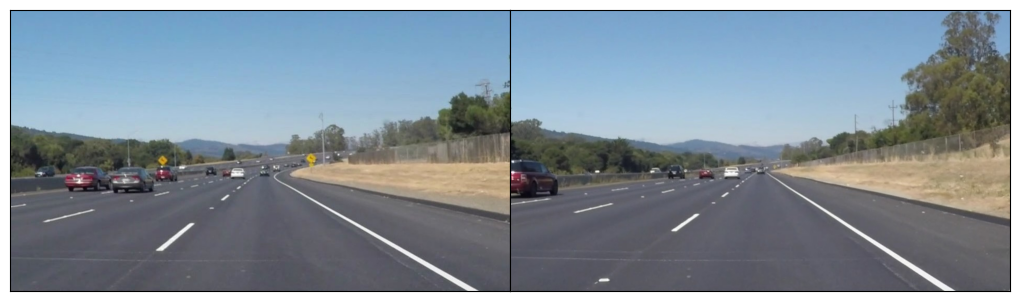

In [31]:
# plot the predicted result

predicted_images = [plt.imread(path) for path in glob.glob('/content/drive/MyDrive/test_images/*.jpg')]

show_images(predicted_images)